In [1]:
import sys
sys.path.append('/opt/ml/code')

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_modules.transform import get_transform
from my_modules.dataset import TrainDataset, EvalDataset
from my_modules.trainer import Trainer
from my_modules.loss import LabelSmoothing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

In [2]:
## seeds

random_seed = 42

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
## hyperparameters

model_name = 'efficientnet-b3' #'tf_efficientnetv2_b3' # 'efficientnet-b0'
device = 'cuda'
batch_size = 64
target = 'age_real'
split = 20

df_train_path = 'df/df_actual_age_train.csv'
df_valid_path = 'df/df_actual_age_valid.csv'
df_test_path = '/opt/ml/input/data/eval/info.csv'

df_train = pd.read_csv(df_train_path)
df_valid = pd.read_csv(df_valid_path)
df_test = pd.read_csv(df_test_path)

In [74]:
## transform

transform_valid = get_transform(augment=False, crop=350, resize=300, cutout=None)

In [75]:
## prepare dataset

#valid_dataset = TrainDataset(df=df_valid, transform=transform_valid, target=target)
valid_dataset = EvalDataset(df=df_test, transform=transform_valid)

In [76]:
## prepare dataloader

dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=3, drop_last=False, shuffle=False)

In [7]:
## prepare model

if model_name.startswith('efficientnet'):
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained(model_name, num_classes=1)
elif model_name.startswith('tf'):
    import timm
    model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=1)
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)
    
model.to(device)
print(model_name, 'ready')

Loaded pretrained weights for efficientnet-b3
efficientnet-b3 ready


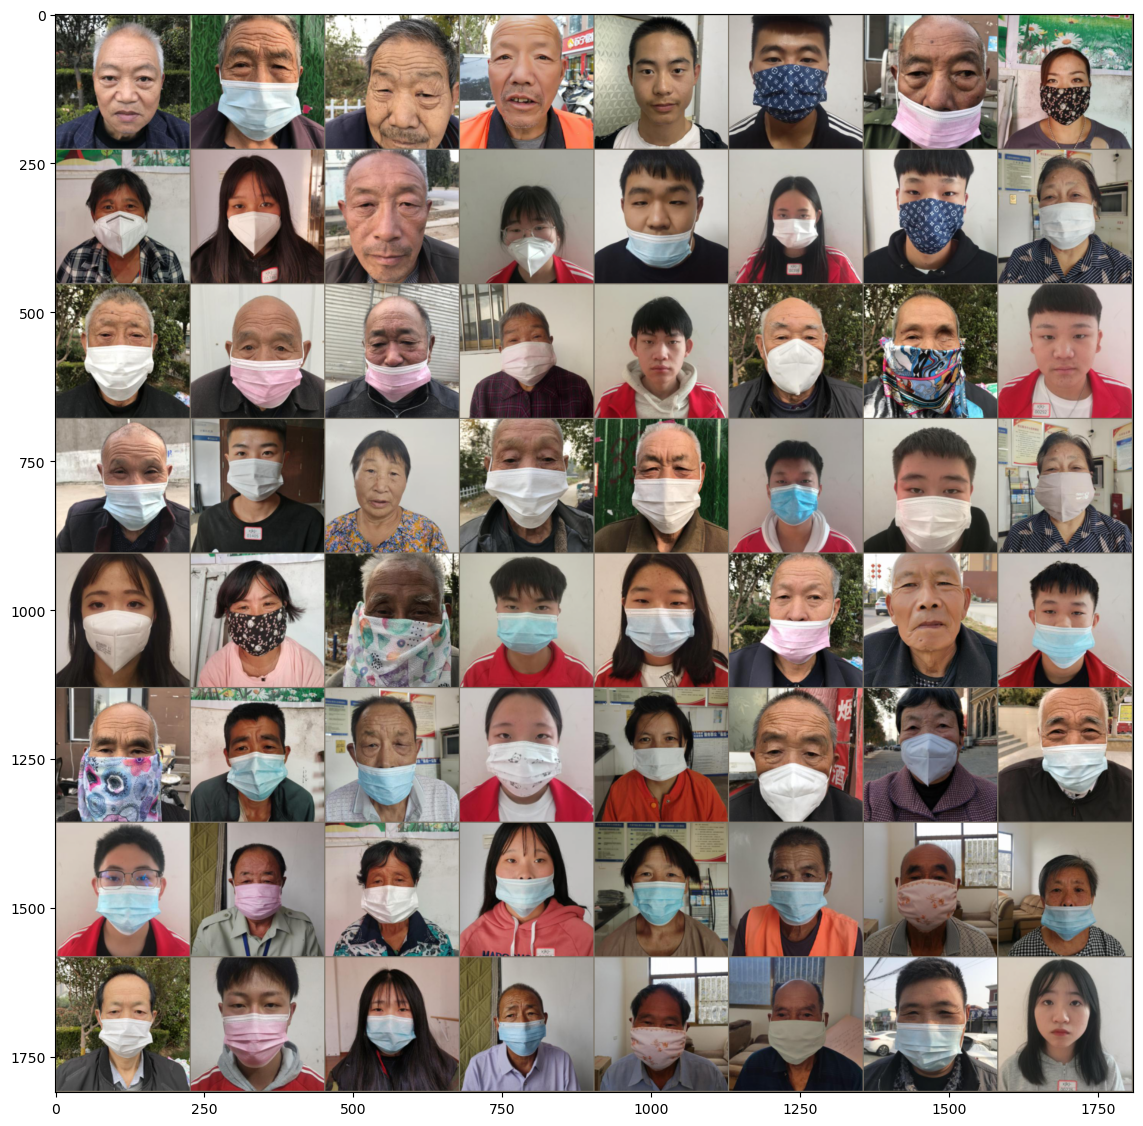

In [8]:
# check input train batch

from my_modules.utils import imshow
batch = next(iter(dataloader))
imshow(batch)

## Test

In [8]:
model.load_state_dict(torch.load('/opt/ml/code/save/age_reg/log3.pt'))
model.eval()
print('ready')

ready


In [9]:
from tqdm import tqdm

model.eval()
y_true = []
y_pred = []

for inputs, labels in tqdm(dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs).squeeze()
        y_true.extend(labels.tolist())
        y_pred.extend(outputs.tolist())

100%|██████████| 60/60 [00:09<00:00,  6.20it/s]


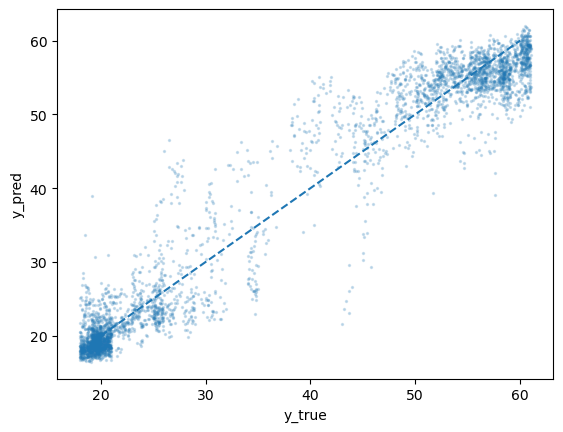

In [10]:
plt.scatter(y_true+np.random.rand(len(y_true)), y_pred, s=2, alpha=0.2)
plt.plot([20,60],[20,60], '--')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.show()

In [11]:
np.corrcoef(y_true, y_pred)

array([[1.      , 0.974828],
       [0.974828, 1.      ]])

In [ ]:
plt.scatter(y_true+np.random.rand(len(y_true)), y_pred, s=2, alpha=0.2)
plt.plot([20,60],[20,60], '--')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.show()

In [ ]:
import pickle

d = {'y_true':y_true, 'y_pred':y_pred}

with open('pkl/result.pkl', 'wb') as f:
    pickle.dump(d, f)

In [18]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

def f(x):
    if x < 30:
        return 0
    if x < 60:
        return 1
    return 2

In [19]:
y_true_cat = [f(x) for x in y_true]

In [20]:
best_f1 = 0
best_ratio = None

for _ in range(100000):
    ratio = np.random.rand(2)
    ratio.sort()
    
    idx_sort = np.argsort(y_pred)
    split1, split2 = round(ratio[0]*len(idx_sort)), round(ratio[1]*len(idx_sort))
    idx_0, idx_1, idx_2 = idx_sort[:split1], idx_sort[split1:split2], idx_sort[split2:]

    y_pred_cat = np.array(y_pred.copy())
    y_pred_cat[idx_0] = 0
    y_pred_cat[idx_1] = 1
    y_pred_cat[idx_2] = 2

    f1 = f1_score(y_true_cat, y_pred_cat, average='macro')
    if f1 > best_f1:
        print(ratio, f1)
        best_f1 = f1
        best_ratio = ratio

[0.01081108 0.82655107] 0.3470743330891737
[0.10445452 0.8009807 ] 0.4472951842153971
[0.4639817  0.57685738] 0.5205958581966347
[0.59484738 0.73886668] 0.5728956107317938
[0.29635761 0.93831573] 0.6812303295833622
[0.35920875 0.82355223] 0.6815173171822875
[0.4773504  0.82069616] 0.7351581006409078
[0.48402057 0.84421233] 0.7513822150119549
[0.41962738 0.9264638 ] 0.7526597885150913
[0.47852837 0.92885955] 0.7788088344687399
[0.47517087 0.94762366] 0.7852520701118139
[0.4863721  0.94096579] 0.785837246826287
[0.47519772 0.94511751] 0.7859372146687251


KeyboardInterrupt: 

In [72]:
len(y_pred)

3780

In [71]:
sorted(y_pred)[round(0.485*len(y_pred))], sorted(y_pred)[round(0.9455*len(y_pred))]

(32.83041763305664, 58.39894104003906)

In [ ]:
best_ratio = [0.47644384 0.92259099] 0.7773226524335848

In [68]:
ratio = [0.485, 0.9455]

idx_sort = np.argsort(y_pred)
split1, split2 = round(ratio[0]*len(idx_sort)), round(ratio[1]*len(idx_sort))
idx_0, idx_1, idx_2 = idx_sort[:split1], idx_sort[split1:split2], idx_sort[split2:]

y_pred_cat = np.array(y_pred.copy())
y_pred_cat[idx_0] = 0
y_pred_cat[idx_1] = 1
y_pred_cat[idx_2] = 2

y_true_cat = [f(x) for x in y_true]

acc = accuracy_score(y_true_cat, y_pred_cat)
f1 = f1_score(y_true_cat, y_pred_cat, average='macro')
print(f'acc:{acc:.4f}, f1:{f1:.4f}')

acc:0.9048, f1:0.7878


In [16]:


mtx = confusion_matrix(y_true_cat, y_pred_cat)
print(mtx)

acc = accuracy_score(y_true_cat, y_pred_cat)
f1 = f1_score(y_true_cat, y_pred_cat, average='macro')
print(f'acc:{acc:.4f}, f1:{f1:.4f}')

[[1729   63    0]
 [  85 1466  164]
 [   0  135  138]]
acc:0.8817, f1:0.7689


In [ ]:
[0.4874988  0.92279958]

In [ ]:


mtx = confusion_matrix(y_true_cat, y_pred_cat)
print(mtx)

acc = accuracy_score(y_true_cat, y_pred_cat)
f1 = f1_score(y_true_cat, y_pred_cat, average='macro')
print(f'acc:{acc:.4f}, f1:{f1:.4f}')

## Inference

In [10]:
model.load_state_dict(torch.load('/opt/ml/code/save/age_reg/log2.pt'))
model.eval()
print('ready')

ready


In [77]:
from tqdm import tqdm

model.eval()
y_pred = []

for inputs in tqdm(dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs).squeeze()
        y_pred.extend(outputs.tolist())

100%|██████████| 197/197 [00:29<00:00,  6.65it/s]


In [78]:
y_pred = np.array(y_pred)

In [90]:
idx_sorted = y_pred.argsort()

In [ ]:
# 0    5334
# 2    3659
# 1    3607

In [91]:
idx0 = idx_sorted[:5334]
idx2 = idx_sorted[-3659:]

In [92]:
age_pred = np.ones(len(y_pred), dtype=np.int32)
age_pred[idx0] = 0
age_pred[idx2] = 2

In [79]:
# idx0 = np.nonzero(y_pred <= 32.83041763305664)
# idx2 = np.nonzero(y_pred > 58.39894104003906)

In [82]:
idx0

(array([    4,     5,     9, ..., 12593, 12594, 12597]),)

In [83]:
len(idx0[0]), len(y_pred) - len(idx0[0]) - len(idx2[0]), len(idx2[0])

(5371, 5999, 1230)

In [ ]:
(32.83041763305664, 58.39894104003906)

In [47]:
age_pred = np.ones(len(y_pred), dtype=np.int32)

In [48]:
age_pred[idx0] = 0
age_pred[idx2] = 2

In [49]:
pd.Series(age_pred).value_counts()

0    5335
1    5163
2    2102
dtype: int64

In [37]:
sorted(y_pred)[round(0.42*len(y_pred))], sorted(y_pred)[round(0.815*len(y_pred))]

(27.441577911376953, 57.84988021850586)

In [19]:
sorted(y_pred)[round(0.48*len(y_pred))], sorted(y_pred)[round(0.92*len(y_pred))]

(29.464128494262695, 58.11812210083008)

/opt/ml/anaconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


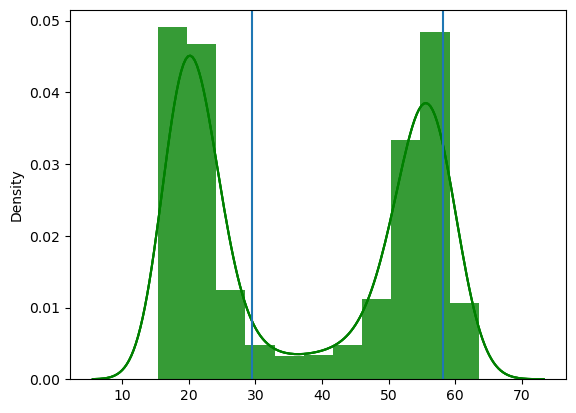

In [22]:
import seaborn as sns
sns.distplot(y_pred, color="green")
plt.axvline(29.464128494262695)
plt.axvline(58.11812210083008)
plt.show()

In [13]:
ratio = [0.48, 0.92]

idx_sort = np.argsort(y_pred)
split1, split2 = round(ratio[0]*len(idx_sort)), round(ratio[1]*len(idx_sort))
idx_0, idx_1, idx_2 = idx_sort[:split1], idx_sort[split1:split2], idx_sort[split2:]

y_pred_cat = np.array(y_pred.copy())
y_pred_cat[idx_0] = 0
y_pred_cat[idx_1] = 1
y_pred_cat[idx_2] = 2

In [93]:
import pickle

with open('pkl/age_pred.pkl', 'wb') as f:
    pickle.dump(age_pred, f)

In [ ]:
label_ = list(range(2 if target=='gender' else 3))

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(mtx, cmap='Blues', vmax=100, vmin=-20)

ax.set_xticks(np.arange(len(label_)))
ax.set_yticks(np.arange(len(label_)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_)
ax.set_yticklabels(label_)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_)):
    for j in range(len(label_)):
        if mtx[i, j]:
            text = ax.text(j, i, mtx[i, j],
                           ha="center", va="center", color="w", size=10)
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')
ax.set_title("Confusion mtx")
fig.tight_layout()
plt.show()

In [ ]:
label_d = {
    'age' : ['< 30', '30~59', ' 60 <='],
    'gender' : ['Male','Female'],
    'mask' : ['Mask', 'Incorrect', 'Normal']
}

iterator = iter(wrong)

label = label_d[target]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for ax in axes.flatten():
    try:
        img, p, t = next(iterator)
    except:
        continue
    img = img.transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f't : {label[t]}\np : {label[p]}')
plt.show()